modules

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
from math import radians, sin, cos, asin, sqrt
import seaborn as sns
from matplotlib.ticker import NullFormatter
import pyproj
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.projections
import tskit
import re
plotdir = 'plots/'

sample locations and metadata

In [2]:
ids = []
ids_file='../data/T2T_Athaliana_66.Chr%d.nomissing.nohet.justSNPs_haploid.samples' %1
with open(ids_file, mode='r') as file:
    next(file); next(file) #skip header and 0 row
    for line in file: 
        ids.append(line.strip().split(' ')[0])

metadata = []
with open('../data/66_genomes_summary.txt','r') as file:
    next(file) #skip header
    for line in file:
        metadata.append(line.strip().split('\t'))
        
accessions = [i[1].strip().replace('_','.').split('.')[0].replace('"','') for i in metadata]
accessions2 = [i[3] for i in metadata]

order = []
for id in ids:
    try:
        ix = accessions.index(id)
    except:
        ix = accessions2.index(id)
    order.append(ix)

group = np.array([i[2] for i in metadata])[order]
population_names, population_ixs = np.unique(group, return_inverse=True)

locations = np.array([list(map(float,[i[7].replace(',','.'),i[6].replace(',','.')])) for i in metadata])[order]
# locations = np.load('../data/T2T_Athaliana_66.Chr1.nomissing.nohet.justSNPs_haploid_locations.npy')

parameters

In [3]:
Ne = 1e5 #prior Ne
m = '7e-9' #prior mutation rate
numiter = 10 #number of MCMC iterations in estimating Ne
threshold = 0.5 #fraction of trees to drop when estimating Ne
nsamples = 1000 #number of trees per locus
tCutoffs = ['None',int(1e6),int(1e5),int(1e4)]

lets try to load the ancestor locations in the same order as the tree sequence, since that is a natural order.

In [117]:
fnss = []
for CHR in range(1,6):
    
    string = '../data/T2T_Athaliana_66.Chr%d.nomissing.nohet.justSNPs_haploid_polarized_masked_%dNe_%sm_popsize_%dnumiter_%.1fthreshold'%(CHR,Ne,m,numiter,threshold) + '_*bps_%dnsamples_%dtCutoff_anc-locs_full-trees.npy'%(nsamples, tCutoff)
    fns = [fn for fn in sorted(glob.iglob(string))]

    starts = [int(re.search('threshold_(.+?)-', fn).group(1)) for fn in fns]
    locus_order = np.argsort(starts)
    fnss.append([fns[i] for i in locus_order])
    
fns = [fn for fns in fnss for fn in fns]

In [118]:
anc_locs = []
for fn in fns:
    anc_locs.append(np.load(fn))

anc_locs = np.array(anc_locs)

L, n, T, d = anc_locs.shape
L, n, T, d

(878, 66, 11, 2)

# Plots

## effective population sizes

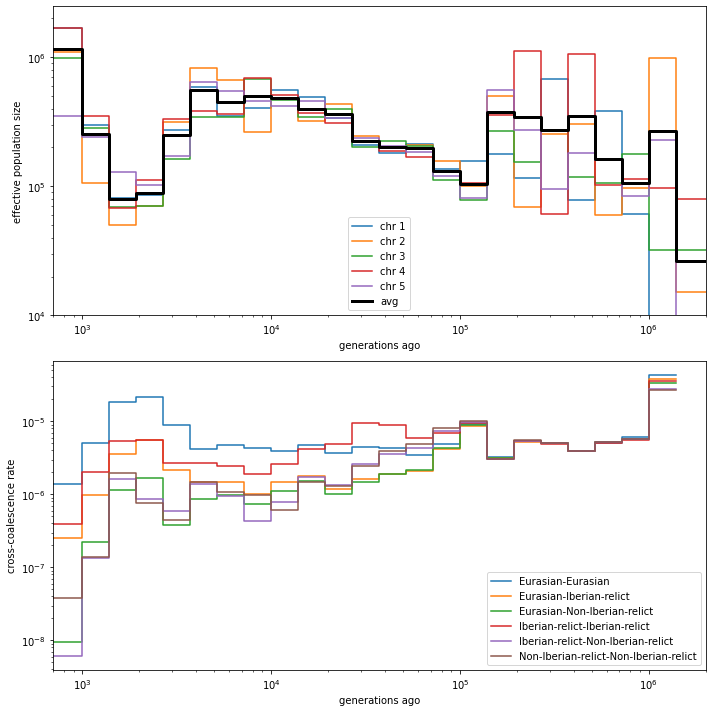

In [24]:
chrs = range(1,6)

pops = ['Eurasian', 'Iberian-relict', 'Non-Iberian-relict']
pop_pairs = [i+'-'+j for i in pops for j in pops]
not_duplicate = [i<=j for i in range(len(pops)) for j in range(len(pops))]

basename = '../data/T2T_Athaliana_66.Chr%d.nomissing.nohet.justSNPs_haploid_polarized_masked_%dNe_%sm_popsize_%dnumiter_%.1fthreshold'
coalfile = basename%(1,Ne,m,numiter,threshold) + '.coal'
epochs = np.genfromtxt(coalfile, skip_header=1, skip_footer=1)

fig, axs = plt.subplots(2,1, figsize=(10,10))

for i,chr in enumerate(chrs):
    coalfile = basename%(chr,Ne,m,numiter,threshold) + '.coal'
    Nes = 0.5/np.genfromtxt(coalfile, skip_header=2)[2:]
    axs[0].step(epochs, Nes, label='chr %d'%chr)
    if i==0:
        all_Nes = Nes
    else:
        all_Nes += Nes
        
    coalfile = basename%(chr,Ne,m,numiter,threshold) + '.pairwise.coal'
    data = np.genfromtxt(coalfile, skip_header=2)[:,2:]
    if i==0:
        all_pairwise_Nes = data
    else:
        all_pairwise_Nes += data
        
all_Nes = all_Nes/len(chrs)
axs[0].step(epochs, all_Nes, label='avg', color='k', linewidth=3)
    
all_pairwise_Nes = all_pairwise_Nes/len(chrs)
for i,pairwise_Ne in enumerate(all_pairwise_Nes):
    if not_duplicate[i]:
        axs[1].step(epochs, pairwise_Ne, label=pop_pairs[i])

for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('generations ago')
    ax.legend()
    ax.set_xlim([7e2,2e6])

axs[0].set_ylabel('effective population size')
axs[0].set_ylim(ymin=1e4)

axs[1].set_ylabel('cross-coalescence rate')

plt.tight_layout()
plt.savefig(plotdir + 'effective-population-sizes.pdf')

plt.show()

## sample locations

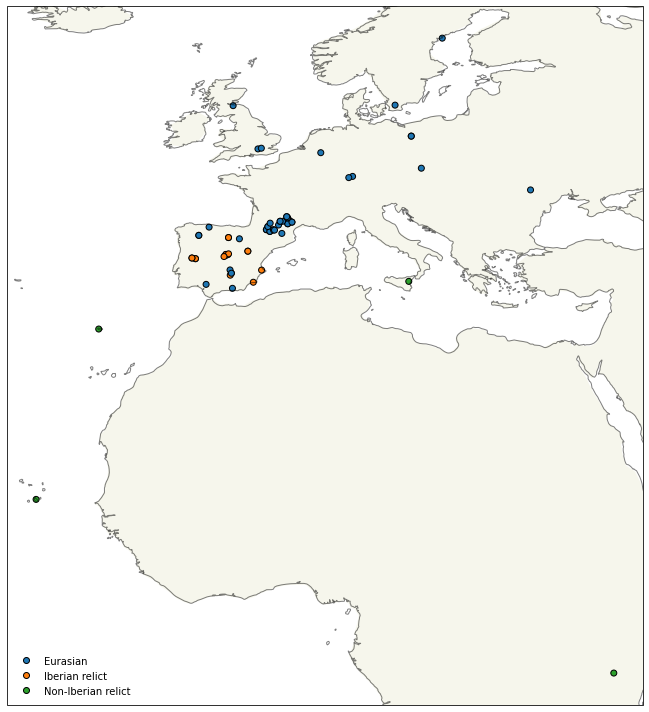

In [5]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection=ccrs.PlateCarree())

cmap = plt.cm.tab10
ax.scatter(locations[:,0], locations[:,1], transform=ccrs.PlateCarree(), color=cmap(population_ixs), edgecolor='k', zorder=1)

ax.coastlines(resolution='50m', alpha=0.5)
ax.add_feature(cfeature.LAND, alpha=0.5)

handles = [plt.Line2D((0,1),(0,0), color=cmap(i), marker='o', linestyle='', markeredgecolor='k') for i in range(3)]
plt.legend(handles, population_names, loc='lower left', frameon=False)

plt.tight_layout()
# plt.savefig(plotdir + 'locations.pdf')
plt.show()

## dispersal rates

In [14]:
fname = '../data/T2T_Athaliana_66.nomissing.nohet.justSNPs_haploid_polarized_masked_%dNe_%sm_popsize_%dnumiter_%.1fthreshold'
fname = fname %(Ne, m, numiter, threshold) + '_1000nsamples_%stCutoff_mle-dispersal.npy'

In [15]:
mles = []
for T in tCutoffs:
    mle = np.load(fname %T, allow_pickle=True)
    mles.append(mle)

In [16]:
meanlon = np.mean(locations[:,0])

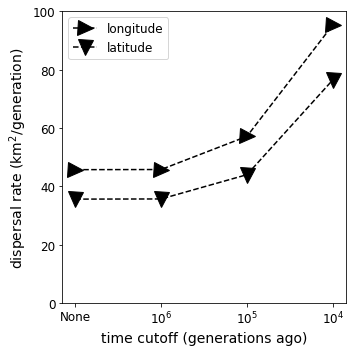

In [97]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.plot(range(len(mles)), [mle[0]**2 * 110**2 for mle in mles], label='longitude', marker='>', color = 'k', markersize=15, linestyle='--')
ax.plot(range(len(mles)), [mle[1]**2 * (np.cos(meanlon * np.pi/180)*111)**2 for mle in mles], label='latitude', marker='v', color = 'k', markersize=15, linestyle='--')

xticks = range(len(mles))
xlabels = ['None', '$10^6$', '$10^5$', '$10^4$']
plt.xticks(xticks, xlabels)
plt.xlabel('time cutoff (generations ago)', fontsize=14)

ax.set_ylim(ymin=0, ymax=100)
ax.set_ylabel('dispersal rate (km$^2$/generation)', fontsize=14)
ax.legend(fontsize=12)#, labelcolor='w', facecolor='k')
ax.tick_params(labelsize=12)

# ax.set_facecolor('k')

plt.tight_layout()
plt.savefig(plotdir + 'dispersal-rates.pdf')
plt.show()

or if you want it in standard deviations (expected distance in given time is proportional to this)

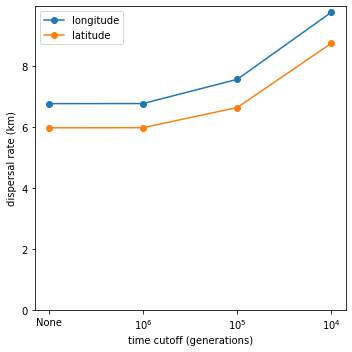

In [12]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.plot(range(len(mles)), [mle[0] * 110 for mle in mles], label='longitude', marker='o')
ax.plot(range(len(mles)), [mle[1] * (np.cos(meanlon * np.pi/180)*111) for mle in mles], label='latitude', marker='o')

xticks = range(len(mles))
xlabels = ['None', '$10^6$', '$10^5$', '$10^4$']
plt.xticks(xticks, xlabels)
plt.xlabel('time cutoff (generations)')

ax.set_ylim(ymin=0)
ax.set_ylabel(r'dispersal rate (km)')
ax.legend()

plt.tight_layout()
# plt.savefig(plotdir + 'dispersal-rates-sd.pdf')
plt.show()

## mean displacements

get mean ancestor locations

In [25]:
time_ix = -1 #choose which time to get ancestor locations at

disps = []
for sample in range(n):

    locs = anc_locs[:,sample,time_ix]
#     row_mask = (locs != locations[sample]).all(axis=1)
#     locs = locs[row_mask,:] #exclude subtrees that contain only the sample
    mean_loc = np.mean(locs, axis=0)
    disp = mean_loc - locations[sample]
    disps.append(disp)

In [26]:
def haversine(loc1, loc2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [loc1[0], loc1[1], loc2[0], loc2[1]])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

get mean displacement distances

In [27]:
dists = [haversine(locations[i], disp) for i,disp in enumerate(disps)]
relative_dists = dists/np.max(dists)

In [28]:
np.mean(dists)

4928.816697705122

color by distance

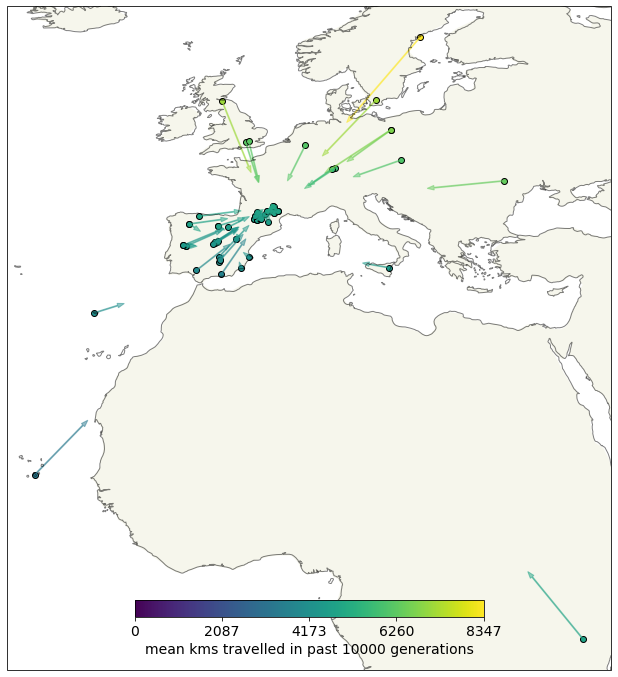

In [29]:
# plot map
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection=ccrs.PlateCarree())
    
for i,disp in enumerate(disps):
    
    cmap = plt.get_cmap('viridis')
    color = cmap(relative_dists[i])
#     color = plt.cm.tab10(population_ixs[i])
    ax.scatter(locations[i,0], locations[i,1], color=color, edgecolor='k', zorder=0)
    ax.arrow(locations[i,0], locations[i,1], disp[0], disp[1], transform=ccrs.PlateCarree(),
             head_width=0.5, length_includes_head=True, width=0.1, alpha=0.5, color=color)

ax.coastlines(resolution='50m', alpha=0.5)
ax.add_feature(cfeature.LAND, alpha=0.5)

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, orientation='horizontal', pad=-0.1, shrink=0.5)
cbar.set_ticks([i/4 for i in range(5)])
cbar.set_ticklabels([round(i*max(dists)/4) for i in range(5)])
cbar.set_label('mean kms travelled in past %d generations' %int(ancestor_times[time_ix]), fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()

plt.show()

could also color by pca group

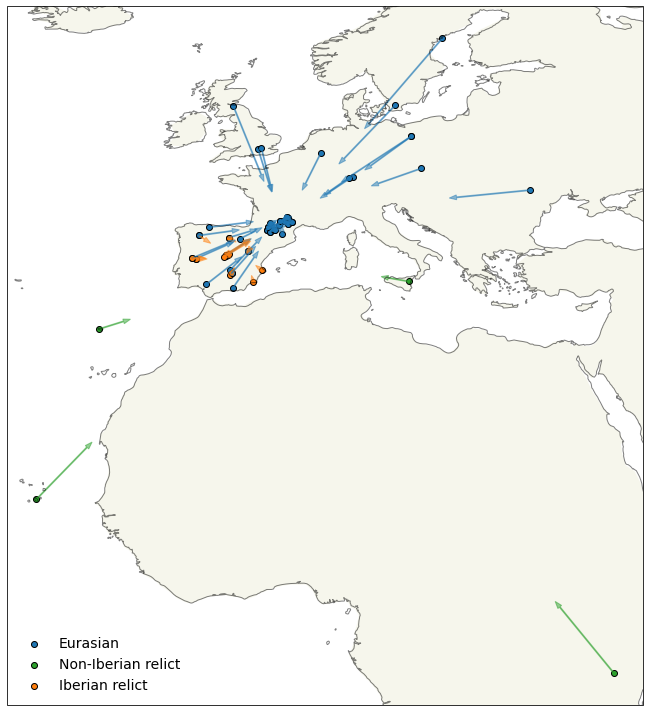

In [33]:
# plot map
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
    
for i,disp in enumerate(disps):
    
    color = plt.cm.tab10(population_ixs[i])
    ax.scatter(locations[i,0], locations[i,1], color=color, edgecolor='k', zorder=0, label=group[i])
    ax.arrow(locations[i,0], locations[i,1], disp[0], disp[1], transform=ccrs.PlateCarree(),
             head_width=0.5, length_includes_head=True, width=0.1, alpha=0.5, color=color)

ax.coastlines(resolution='50m', alpha=0.5)
ax.add_feature(cfeature.LAND, alpha=0.5)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='lower left', frameon=False, fontsize=14)

plt.tight_layout()

plt.savefig(plotdir + 'mean-displacements.pdf')
plt.show()

this nicely shows that most Iberian relicts stay put, relative to Eurasians in Spain

## ancestor clouds

In [5]:
cmaps = [plt.cm.Blues, plt.cm.Oranges, plt.cm.Greens] #to roughly align with color scheme above

def ancestor_clouds(sample, extent=None, time_ixs = range(8,11), levels=10, bw_adjust=1, filename=None):
    
    cmap = cmaps[population_ixs[sample]]

    fig, axs = plt.subplots(1,len(time_ixs),figsize=(5*len(time_ixs), 5),subplot_kw={'projection': ccrs.PlateCarree()})

    print(ids[sample])
    for ax,time_ix in zip(axs,time_ixs):
        
        print(int(ancestor_times[time_ix]))
        
        locs = anc_locs[:,sample,time_ix]
#         row_mask = (locs != locations[sample]).all(axis=1)
#         locs = locs[row_mask,:] #exclude subtrees that contain only the sample
    
        sns.kdeplot(x=locs[:,0], y=locs[:,1], transform=ccrs.PlateCarree(), ax=ax, levels=levels, color=plt.cm.tab10(population_ixs[sample]), bw_adjust=bw_adjust, zorder=0)#fill=True, , cmap=cmap
        ax.scatter(locs[:,0], locs[:,1], transform=ccrs.PlateCarree(), color=plt.cm.tab10(population_ixs[sample]), alpha=0.1)

        ax.scatter(locations[sample,0], locations[sample,1], transform=ccrs.PlateCarree(), color=plt.cm.tab10(population_ixs[sample]), edgecolor='k')
#         ax.scatter(locations[:,0], locations[:,1], transform=ccrs.PlateCarree(), color=plt.cm.tab10(population_ixs), alpha=0.1)
        
#         ax.set_title(int(ancestor_times[time_ix]))
        ax.coastlines(resolution='50m', alpha=0.5)
        ax.add_feature(cfeature.LAND, alpha=0.5)
        
        if extent is not None:
            ax.set_extent(extent, crs=ccrs.PlateCarree())

    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)
        
    plt.show()

an interesting example from each PCA group

rapid south-north migration in Eurasians

6137
1000
5000
10000


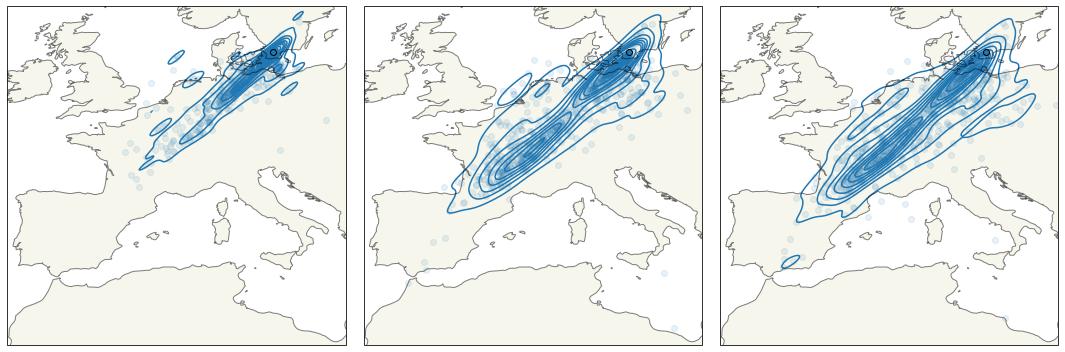

In [233]:
extent = [-10,20,30,60]
filename = plotdir + 'sample0-cloud.pdf'
# filename = None
ancestor_clouds(0, extent=extent, bw_adjust=0.75, time_ixs = [1,5,10], filename=filename)

lots of Eurasian ancestry in this Iberian relict

Met-6
1000
5000
10000


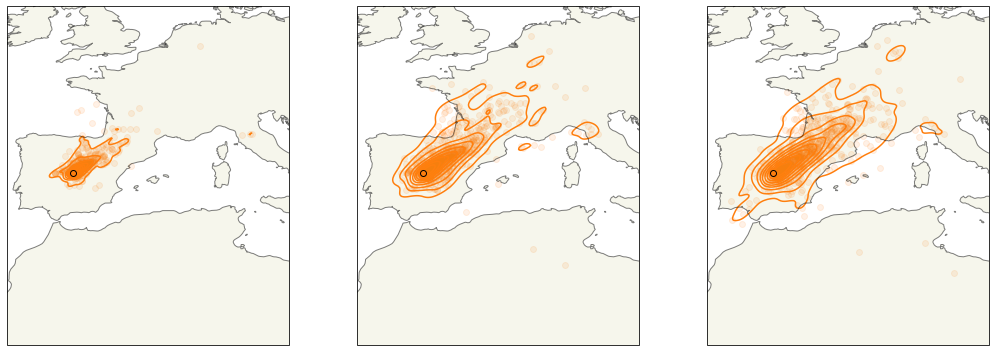

In [234]:
extent = [-10,15,25,55]
filename = plotdir + 'sample59-cloud.pdf'
# filename = None
ancestor_clouds(59, extent=extent, bw_adjust=0.75, time_ixs = [1,5,10], filename=filename)

and this one

Evs-12
1000
5000
10000


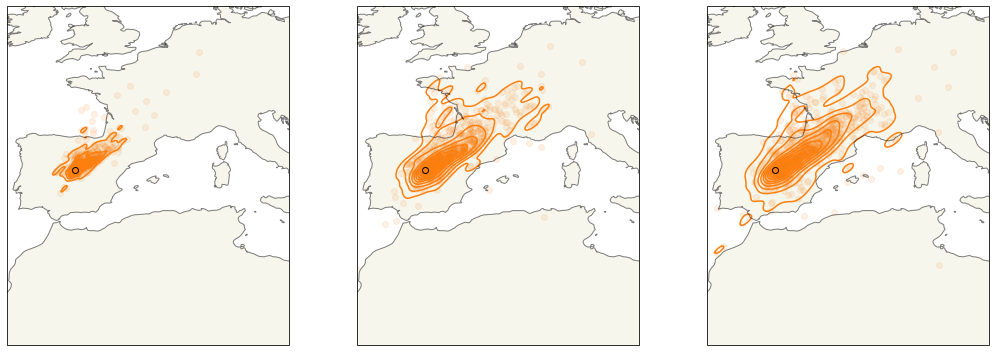

In [6]:
extent = [-10,15,25,55]
filename = plotdir + 'sample43-cloud.pdf'
filename = None
ancestor_clouds(43, extent=extent, bw_adjust=0.75, time_ixs = [1,5,10], filename=filename)

can compare to eurasian in spain

9883
1000
5000
10000


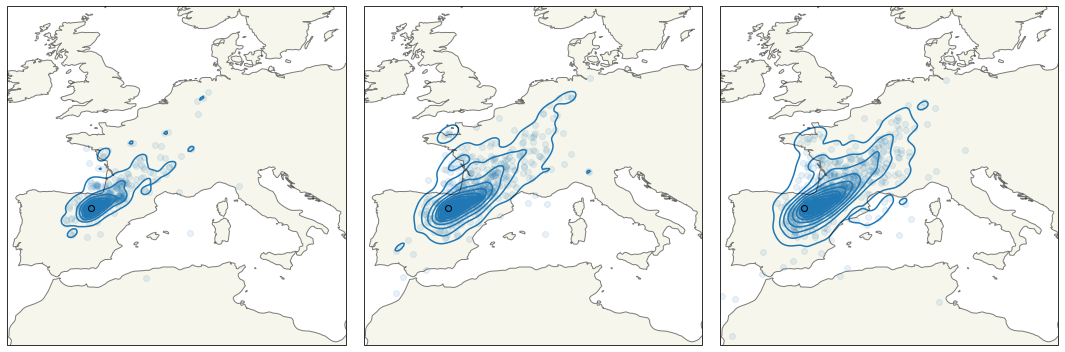

In [33]:
extent = [-10,20,30,60]
filename = plotdir + 'sample14-cloud.pdf'
filename = None
ancestor_clouds(14, extent=extent, bw_adjust=0.75, time_ixs = [1,5,10], filename=filename)

very varied ancestry in this Iberian relict, including lots of non-Iberian relict relations

Hum-2
1000
5000
10000


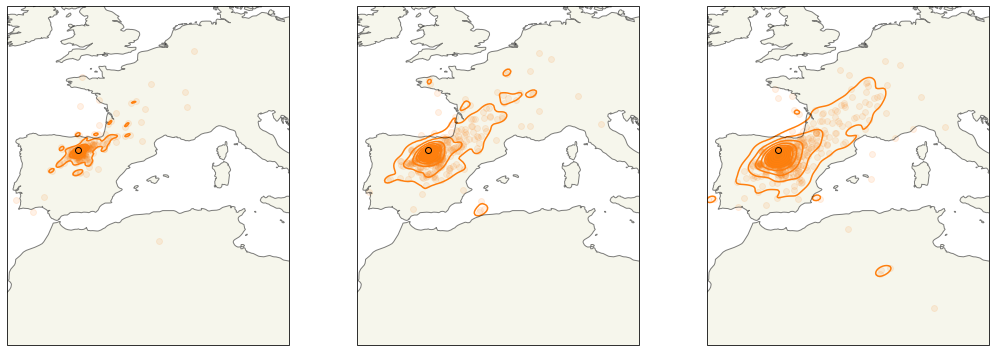

In [236]:
extent = [-10,15,25,55]
filename=plotdir + 'sample39-cloud.pdf'
# filename = None
ancestor_clouds(39, extent=extent, bw_adjust=0.75, time_ixs = [1,5,10], filename=filename)

slower migration of non-Iberian relicts

Cvi-0
1000
5000
10000


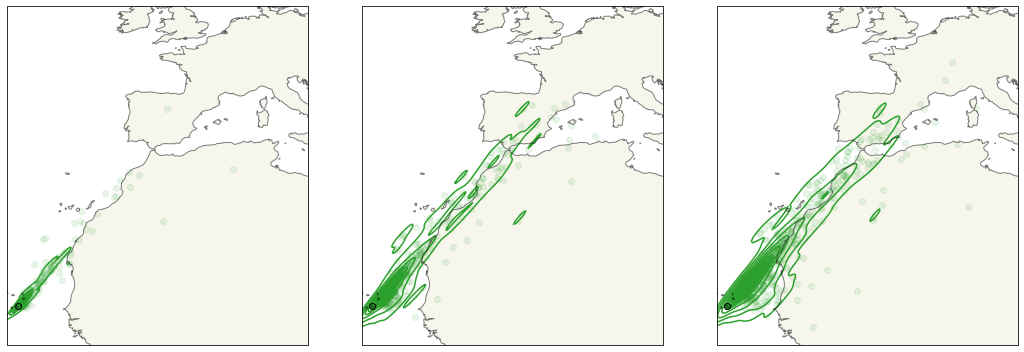

In [237]:
extent = [-25,15,10,55]
filename=plotdir + 'sample20-cloud.pdf'
# filename = None
ancestor_clouds(20, extent=extent, bw_adjust=0.75, time_ixs = [1,5,10], filename=filename)

especially the most deeply diverged madeiran sample

22005
1000
5000
10000


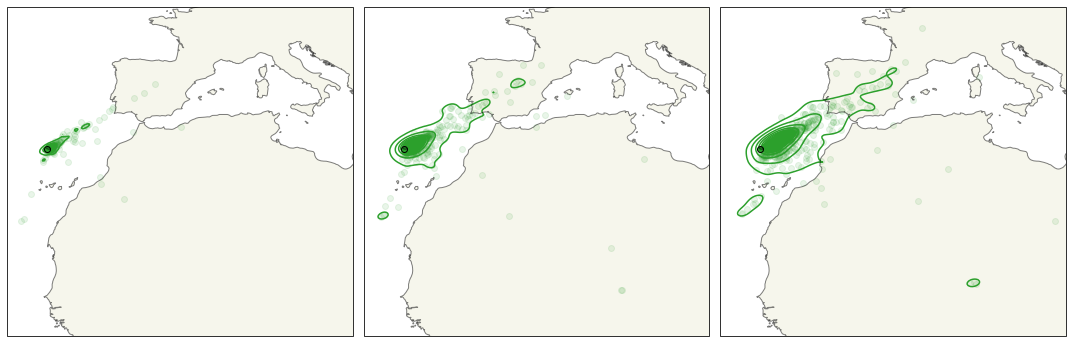

In [108]:
extent = [-22,20,10,50]
filename=plotdir + 'sample42-cloud.pdf'
# filename = None
ancestor_clouds(42, extent=extent, bw_adjust=0.75, time_ixs = [1,5,10], filename=filename)

which moves so much less than the most northerly eurasian

9336
1000
5000
10000


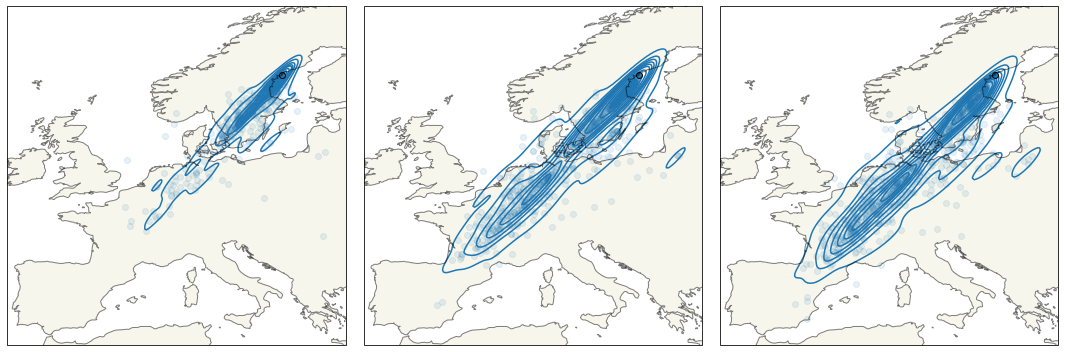

In [18]:
extent = [-10,25,35,70]
filename=plotdir + 'sample12-cloud.pdf'
# filename = None
ancestor_clouds(12, extent=extent, bw_adjust=0.75, time_ixs = [1,5,10], filename=filename)

here are two eurasians with lots of relict ancestry

9852
1000
5000
10000


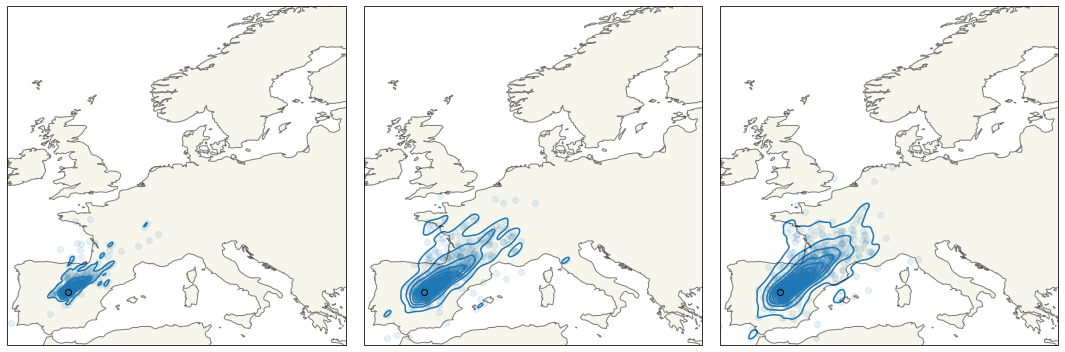

In [98]:
extent = [-10,25,35,70]
filename=plotdir + 'sample13-cloud.pdf'
filename = None
ancestor_clouds(13, extent=extent, bw_adjust=0.75, time_ixs = [1,5,10], filename=filename)

Evs-0
1000
5000
10000


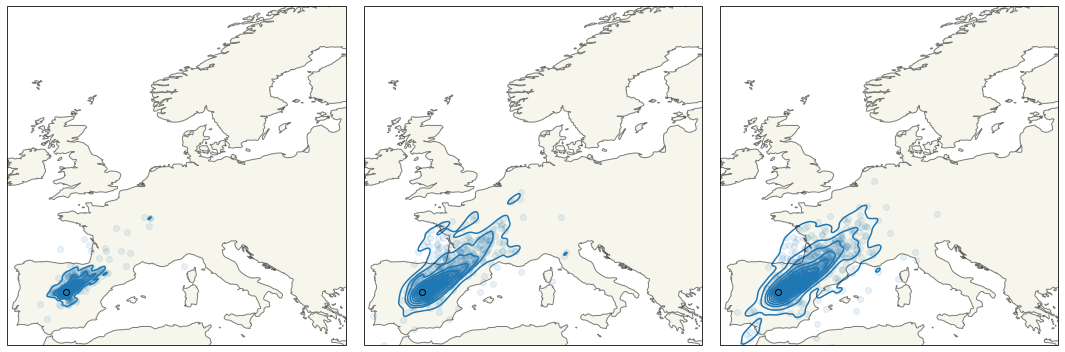

In [99]:
extent = [-10,25,35,70]
filename=plotdir + 'sample17-cloud.pdf'
filename = None
ancestor_clouds(17, extent=extent, bw_adjust=0.75, time_ixs = [1,5,10], filename=filename)

## colouring ancestors by genealogical nearest neighbours

load the tree sequences for each chromosome

In [112]:
basename = '../data/T2T_Athaliana_66.Chr%d.nomissing.nohet.justSNPs_haploid_polarized_masked_%dNe_%sm_popsize_%dnumiter_%.1fthreshold'
filename = basename + '.trees'
tss = []
for i in range(5):
    tss.append(tskit.load(filename %(i+1,Ne,m,numiter,threshold)))

define the (windowed) genealogical nearest neighbors (from https://github.com/tskit-dev/tskit/pull/683/commits/2b019a0091f0911e3245ff1e76c7902dc8d5d78e)

In [113]:
def parse_time_windows(ts, time_windows):
    if time_windows is None:
        time_windows = [0.0, ts.max_root_time]
    return np.array(time_windows)


def windowed_genealogical_nearest_neighbours(
    ts,
    focal,
    reference_sets,
    windows=None,
    time_windows=None,
    span_normalise=True,
    time_normalise=True,
):
    """
    genealogical_nearest_neighbours with support for span- and time-based windows
    """
    reference_set_map = np.full(ts.num_nodes, tskit.NULL, dtype=int)
    for k, reference_set in enumerate(reference_sets):
        for u in reference_set:
            if reference_set_map[u] != tskit.NULL:
                raise ValueError("Duplicate value in reference sets")
            reference_set_map[u] = k

    windows_used = windows is not None
    time_windows_used = time_windows is not None
    windows = ts.parse_windows(windows)
    num_windows = windows.shape[0] - 1
    time_windows = parse_time_windows(ts, time_windows)
    num_time_windows = time_windows.shape[0] - 1
    A = np.zeros((num_windows, num_time_windows, len(focal), len(reference_sets)))
    K = len(reference_sets)
    parent = np.full(ts.num_nodes, tskit.NULL, dtype=int)
    sample_count = np.zeros((ts.num_nodes, K), dtype=int)
    time = ts.tables.nodes.time
    norm = np.zeros((num_windows, num_time_windows, len(focal)))

    # Set the initial conditions.
    for j in range(K):
        sample_count[reference_sets[j], j] = 1

    window_index = 0
    for (t_left, t_right), edges_out, edges_in in ts.edge_diffs():
        for edge in edges_out:
            parent[edge.child] = tskit.NULL
            v = edge.parent
            while v != tskit.NULL:
                sample_count[v] -= sample_count[edge.child]
                v = parent[v]
        for edge in edges_in:
            parent[edge.child] = edge.parent
            v = edge.parent
            while v != tskit.NULL:
                sample_count[v] += sample_count[edge.child]
                v = parent[v]

        # Update the windows
        assert window_index < num_windows
        while windows[window_index] < t_right and window_index + 1 <= num_windows:
            w_left = windows[window_index]
            w_right = windows[window_index + 1]
            left = max(t_left, w_left)
            right = min(t_right, w_right)
            span = right - left
            # Process this tree.
            for j, u in enumerate(focal):
                focal_reference_set = reference_set_map[u]
                delta = int(focal_reference_set != tskit.NULL)
                p = u
                while p != tskit.NULL:
                    total = np.sum(sample_count[p])
                    if total > delta:
                        break
                    p = parent[p]
                if p != tskit.NULL:
                    scale = span / (total - delta)
                    time_index = np.searchsorted(time_windows, time[p]) - 1
                    if 0 <= time_index < num_time_windows:
                        for k in range(len(reference_sets)):
                            n = sample_count[p, k] - int(focal_reference_set == k)
                            A[window_index, time_index, j, k] += n * scale
                        norm[window_index, time_index, j] += span
            assert span > 0
            if w_right <= t_right:
                window_index += 1
            else:
                # This interval crosses a tree boundary, so we update it again
                # in the next tree
                break

    # Reshape norm depending on normalization selected
    # Return NaN when normalisation value is 0
    if span_normalise and time_normalise:
        reshaped_norm = norm.reshape((num_windows, num_time_windows, len(focal), 1))
    elif span_normalise and not time_normalise:
        norm = np.sum(norm, axis=1)
        reshaped_norm = norm.reshape((num_windows, 1, len(focal), 1))
    elif time_normalise and not span_normalise:
        norm = np.sum(norm, axis=0)
        reshaped_norm = norm.reshape((1, num_time_windows, len(focal), 1))

    with np.errstate(invalid="ignore", divide="ignore"):
        A /= reshaped_norm
    A[np.all(A == 0, axis=3)] = np.nan

    # Remove dimension for windows and/or time_windows if parameter is None
    if not windows_used and time_windows_used:
        A = A.reshape((num_time_windows, len(focal), len(reference_sets)))
    elif not time_windows_used and windows_used:
        A = A.reshape((num_windows, len(focal), len(reference_sets)))
    elif not windows_used and not time_windows_used:
        A = A.reshape((len(focal), len(reference_sets)))
    return A

define plot

In [124]:
def gnn_ancestor_clouds(sample, extent=None, time_ixs = range(8,11), levels=10, bw_adjust=1, filename=None):
    
    # first get gnns
    wgnns = []
    for ts in tss:
        wgnn = windowed_genealogical_nearest_neighbours(ts, [sample], [np.where(population_ixs==i)[0].astype('int32') for i in range(2)], windows='trees')[::100]
        wgnns.append(wgnn[:,0,0]) #append proportion Eurasian at each locus
    wgnns = np.concatenate(wgnns)
    
    # and define color of ancestor as interpolation between blue and orange based on gnn
    colors = np.array([i*wgnns for i in plt.cm.tab10(0)]).transpose().reshape(L,4) + np.array([i*(1-wgnns) for i in plt.cm.tab10(1)]).transpose().reshape(L,4)
    
    # now plot
    fig, axs = plt.subplots(1,len(time_ixs),figsize=(5*len(time_ixs), 5),subplot_kw={'projection': ccrs.PlateCarree()})

    print(ids[sample])
    for ax,time_ix in zip(axs,time_ixs):
        
        print(int(ancestor_times[time_ix]))
        
        locs = anc_locs[:,sample,time_ix]

#         sns.kdeplot(x=locs[:,0], y=locs[:,1], transform=ccrs.PlateCarree(), ax=ax, levels=levels, color=plt.cm.tab10(population_ixs[sample]), bw_adjust=bw_adjust, zorder=0)#fill=True, , cmap=cmap
        ax.scatter(locs[:,0], locs[:,1], transform=ccrs.PlateCarree(), color=colors, alpha=0.5)

        ax.scatter(locations[sample,0], locations[sample,1], transform=ccrs.PlateCarree(), color=plt.cm.tab10(population_ixs[sample]), edgecolor='k')
        
        ax.coastlines(resolution='50m', alpha=0.5)
        ax.add_feature(cfeature.LAND, alpha=0.5)
        
        if extent is not None:
            ax.set_extent(extent, crs=ccrs.PlateCarree())

    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)
        
    plt.show()

for the two swedish samples

9336
1000
5000
10000


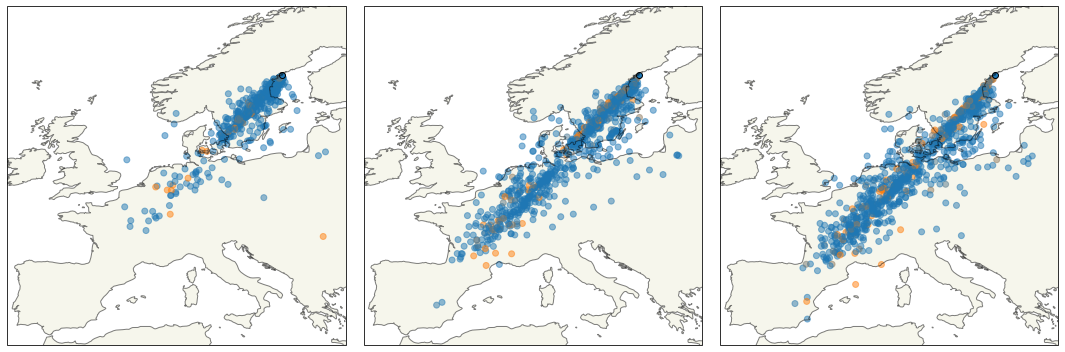

In [125]:
extent = [-10,25,35,70]
filename = None
gnn_ancestor_clouds(12, extent=extent, bw_adjust=0.75, time_ixs = [1,5,10], filename=filename)

6137
1000
5000
10000


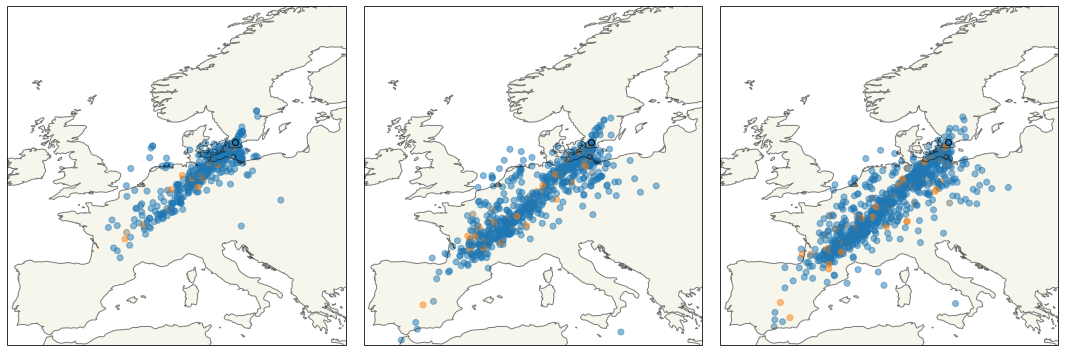

In [126]:
extent = [-10,25,35,70]
filename = None
gnn_ancestor_clouds(0, extent=extent, bw_adjust=0.75, time_ixs = [1,5,10], filename=filename)

might be more fun for a very admixed individual?

9852
1000
5000
10000


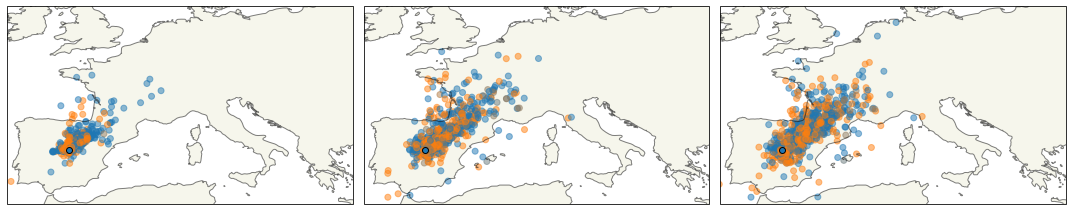

In [127]:
extent = [-10,25,35,55]
filename = None
gnn_ancestor_clouds(13, extent=extent, bw_adjust=0.75, time_ixs = [1,5,10], filename=filename)

not really, i think because the gnn isnt telling us much more than the sister sample at that tree?

## 2d histograms

also extended to combine samples together

In [100]:
cmaps = [plt.cm.Blues, plt.cm.Oranges, plt.cm.Greens] #to roughly align with color scheme above

def map_hist(groups, extent=None, time_ixs = [1,5,10], levels=10, bw_adjust=1, filename=None):

    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    
    for time_ix in time_ixs:
        print(int(ancestor_times[time_ix]))

        plt.figure(1, figsize=(8, 8))
        axScatter = plt.axes(rect_scatter, projection=ccrs.PlateCarree())
        axHistx = plt.axes(rect_histx)
        axHisty = plt.axes(rect_histy)
        
        for group in groups:

            all_locs = np.empty((1,2))
            for sample in group: 

                locs = anc_locs[:,sample,time_ix]
#                 row_mask = (locs != locations[sample]).all(axis=1)
#                 locs = locs[row_mask,:] #exclude subtrees that contain only the sample
                all_locs = np.vstack([all_locs, locs])
            all_locs = all_locs[1:] #drop the empty row
            
#             axScatter.scatter(x=all_locs[:,0], y=all_locs[:,1], transform=ccrs.PlateCarree())
            sns.kdeplot(x=all_locs[:,0], y=all_locs[:,1], transform=ccrs.PlateCarree(), ax=axScatter, levels=levels, bw_adjust=bw_adjust, zorder=0)#fill=True, , cmap=cmap

#             axHistx.hist(all_locs[:,0], bins=50, density=True, alpha=0.5)
            sns.kdeplot(x=all_locs[:,0], ax=axHistx, bw_adjust=bw_adjust, fill=True)
#             axHisty.hist(all_locs[:,1], bins=50, orientation='horizontal', density=True, alpha=0.5)
            sns.kdeplot(y=all_locs[:,1], ax=axHisty, bw_adjust=bw_adjust, fill=True)

        axScatter.coastlines(resolution='50m', alpha=0.5)
        axScatter.add_feature(cfeature.LAND, alpha=0.5)

        if extent is not None:
            axScatter.set_extent(extent, crs=ccrs.PlateCarree())
        
        axHistx.set_xlim(axScatter.get_xlim())
        axHisty.set_ylim(axScatter.get_ylim())
        nullfmt = NullFormatter()         # no labels
        axHistx.xaxis.set_major_formatter(nullfmt)
        axHistx.yaxis.set_major_formatter(nullfmt)
        axHisty.xaxis.set_major_formatter(nullfmt)
        axHisty.yaxis.set_major_formatter(nullfmt)
        axHistx.set(ylabel=None) 
        axHisty.set(xlabel=None)
        
        plt.tight_layout()
        
        if filename is not None:
            plt.savefig(filename + '-' + str(time_ix) + '.pdf')

        plt.show()

look at all the ancestors of each PCA group

1000


/tmp/ipykernel_52690/2320847629.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


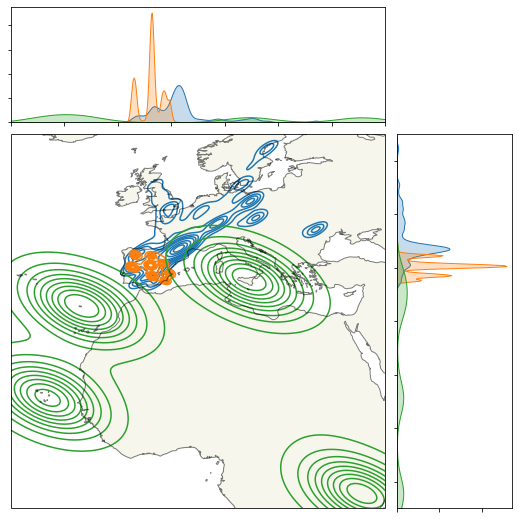

5000


/tmp/ipykernel_52690/2320847629.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


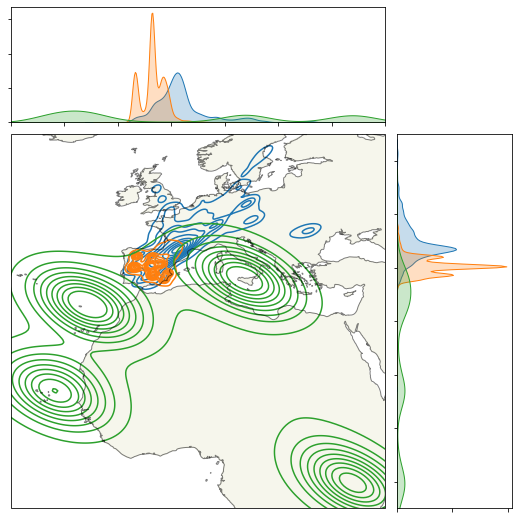

10000


/tmp/ipykernel_52690/2320847629.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


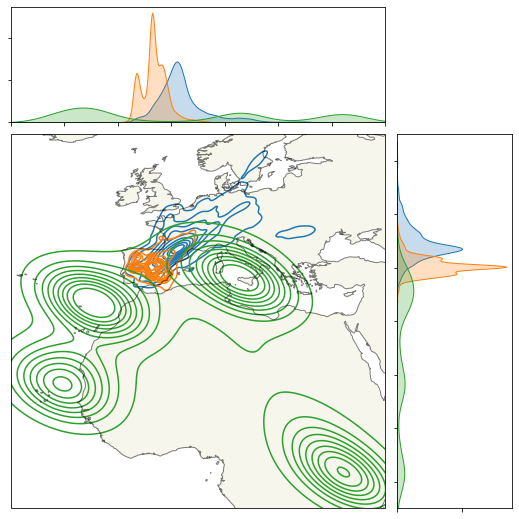

In [247]:
extent = [-30,40,-5,65] #subplots only lining up when square
filename = plotdir + 'pca-clouds'
# filename = None
map_hist([np.where(population_ixs==0)[0], np.where(population_ixs==1)[0], np.where(population_ixs==2)[0]], filename=filename, extent=extent)

compare relict vs non relict in spain

In [101]:
np.where(population_ixs==1)[0]

array([ 4, 21, 24, 25, 29, 34, 39, 43, 45, 53, 57, 59, 61])

In [102]:
group1 = []
for i in range(n):
    if locations[i,0]>-10 and locations[i,0]<0 and locations[i,1]>36 and locations[i,1]<45 and population_ixs[i]==0:
        group1.append(i)

1000


/tmp/ipykernel_235985/2320847629.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


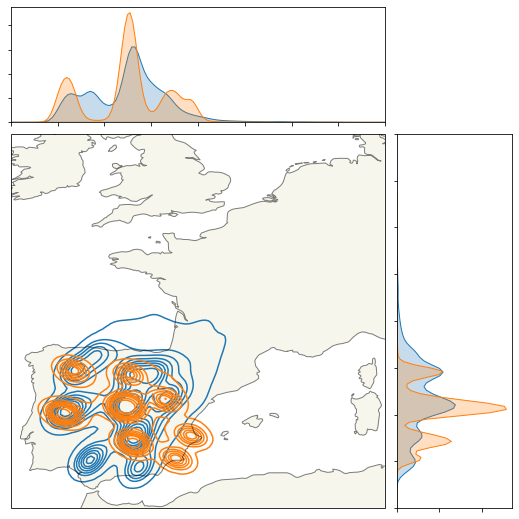

5000


/tmp/ipykernel_235985/2320847629.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


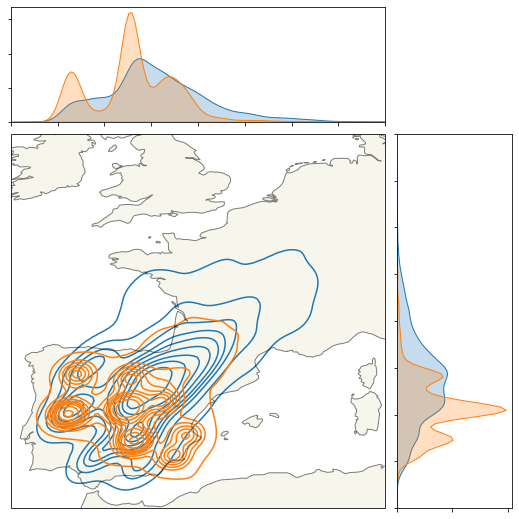

10000


/tmp/ipykernel_235985/2320847629.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


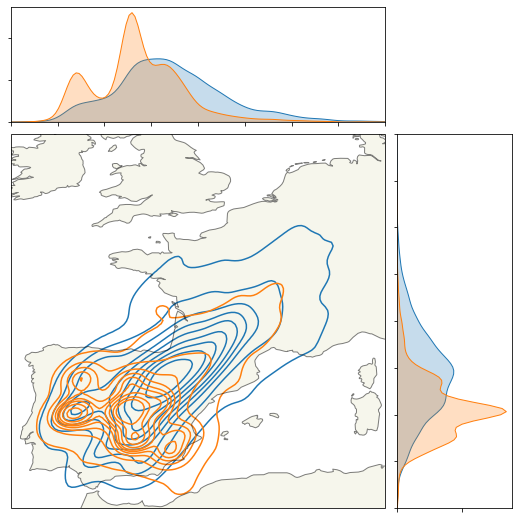

In [106]:
extent = [-10,10,35,55]
# extent=None
filename = plotdir + 'relict-vs-nonrelict-clouds'
# filename = None
map_hist([group1, np.where(population_ixs==1)[0]], extent=extent, filename=filename)

notice the Eurasian lineages move further north and east relative to Iberian relicts, but lots of variation

## Windroses

In [8]:
cmaps = [plt.cm.Blues, plt.cm.Oranges, plt.cm.Greens] #to roughly align with color scheme above

def polar_plot(bearings, ax=None, n=36, color='k'):

    bins = np.arange(n + 1) * 360 / n
    width =  2 * np.pi / n

    frequencies, division = np.histogram(bearings, bins=bins, density=True)
    division = division[:-1]
    xs = division * np.pi / 180
        
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = plt.axes(polar=True)
        
    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')    
        
    bars = ax.bar(xs, frequencies, width=width, align='center', zorder=2, edgecolor='k', linewidth=0.5, alpha=0.7, color=color)
#     sns.kdeplot(x=bearings* np.pi / 180, ax=ax, fill=True, color=color, bw_adjust=0.5)
#     ax.set_ylabel(None)

    ax.set_yticklabels(labels=[])
    ax.set_xticklabels(labels=[])
    
def windrose(sample, extent=None, time_ix=-1, filename=None):
    
    print(ids[sample])
    int(ancestor_times[time_ix])
    
    # set up plot
    fig = plt.figure(figsize=(10, 10))
    plateCr = ccrs.PlateCarree()
    plateCr._threshold = plateCr._threshold/100.  #set finer threshold for smoother great circle lines
    ax = plt.axes(projection=plateCr)

    # get ancestor locations
    locs = anc_locs[:,sample,time_ix]
#     row_mask = (locs != locations[sample]).all(axis=1)
#     locs = locs[row_mask,:] #exclude subtrees that contain only the sample

    # plot the displacement at each locus as great circle
    for loc in locs:
        lons = np.vstack([locations[sample,0],loc[0]])
        lats = np.vstack([locations[sample,1],loc[1]])
        ax.plot(lons, lats, transform=ccrs.Geodetic(), color=plt.cm.tab10(population_ixs[sample]), alpha=0.5)

    # windrose inset
    geodesic = pyproj.Geod(ellps='WGS84')
    L,d = locs.shape
    bearings = np.zeros(L)
    distances = np.zeros(L)
    for i,(long,lat) in enumerate(locs):
        az1,_,d = geodesic.inv(locations[sample,0],locations[sample,1], long, lat)
        if az1 < 0:
            az1 = 360 + az1
        bearings[i] = az1
        distances[i] = d
    inset_ax = inset_axes(ax, bbox_to_anchor=(locations[sample,0],locations[sample,1]), bbox_transform=ax.transData, 
                          width=1, height=1, loc='center', axes_class=matplotlib.projections.get_projection_class('polar'))
    polar_plot(ax=inset_ax, bearings=bearings, color=plt.cm.tab10(population_ixs[sample]))
    
    # styling
#     ax.set_title(int(ancestor_times[time_ix]))
    ax.coastlines(resolution='50m', alpha=0.5)
    ax.add_feature(cfeature.LAND, alpha=0.5)
    if extent is not None:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)

    plt.show()

here is a fairly typical Iberian relict

Hum-2


/tmp/ipykernel_235985/2641269890.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


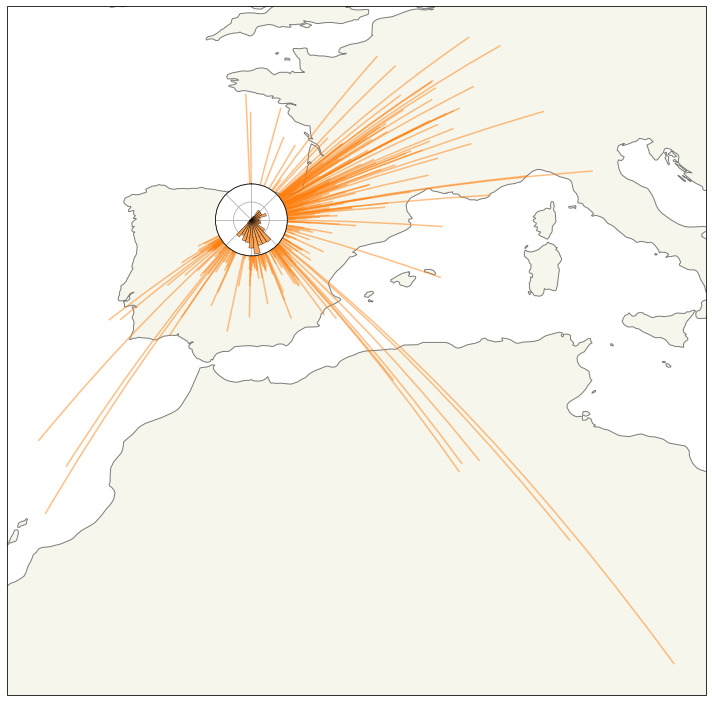

In [9]:
filename = plotdir + 'windrose39.pdf'
filename = None
windrose(39, filename=filename)

and compare to a typical Spanish Eurasian

9883


/tmp/ipykernel_235985/2641269890.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


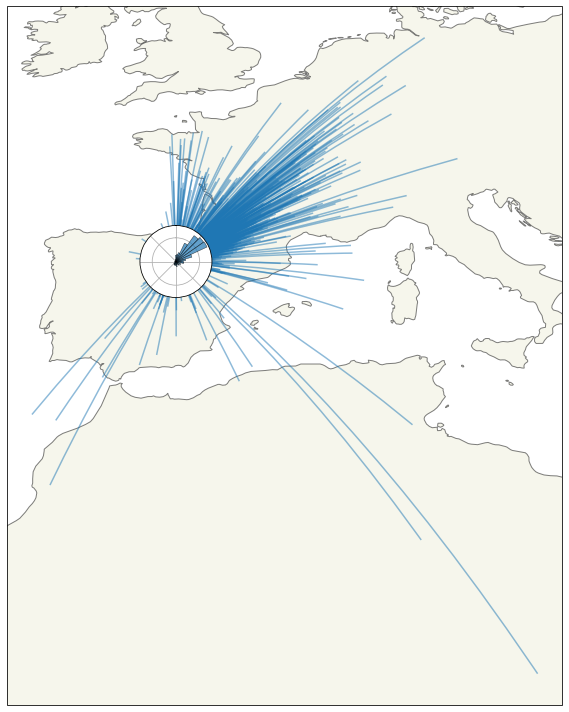

In [10]:
filename = plotdir + 'windrose14.pdf'
filename = None
windrose(14, filename=filename)

and then the two outlier Iberian relicts

Met-6


/tmp/ipykernel_235985/2641269890.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


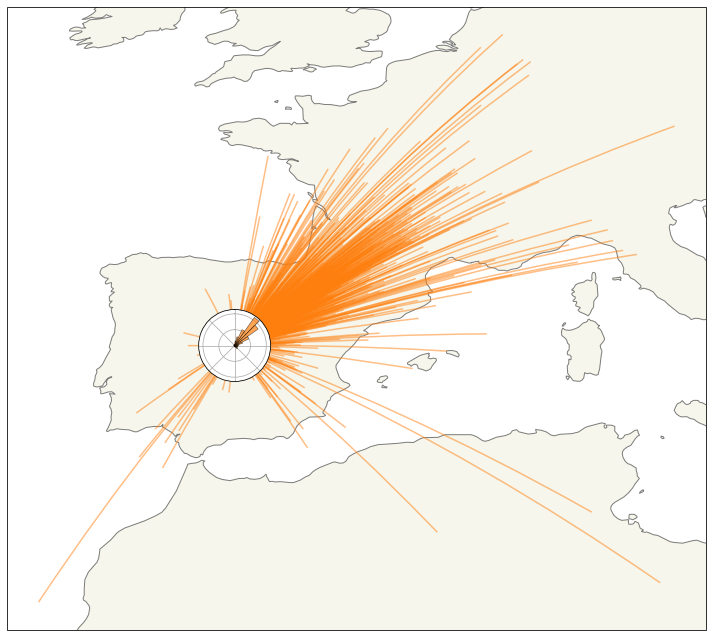

In [11]:
filename = plotdir + 'windrose59.pdf'
filename = None
windrose(59, filename=filename)

Evs-12


/tmp/ipykernel_235985/2641269890.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


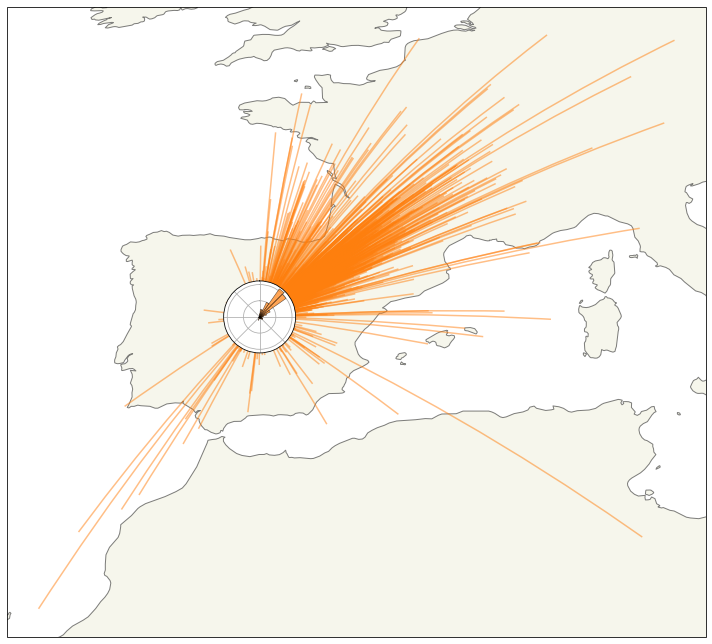

In [13]:
filename = plotdir + 'windrose43.pdf'
# filename = None
windrose(43, filename=filename)